In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

def plot_histogram(data, num_bins, bottom=None):
    plt.hist(data, bins=num_bins, bottom=bottom, color='blue', alpha=0.7)
    plt.xlabel('z value')
    plt.ylabel('Frequency')
    plt.title('Sensor calibration errors, normalised by standard deviation')

# Load data from CSV file
def load_data_from_csv(file_path):
    data = pd.read_csv(file_path)
    return data

# where to save plots
overwrite = True
save_path = "/home/luke/Documents/thesis_plots/"

import sys
pathhere = "/home/luke/mujoco-devel/rl/"
sys.path.insert(0, pathhere)
from env.MjEnv import MjEnv
mjenv = MjEnv()
from TrainingManager import TrainingManager

/tmp/ipykernel_88613/300713432.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(labels)


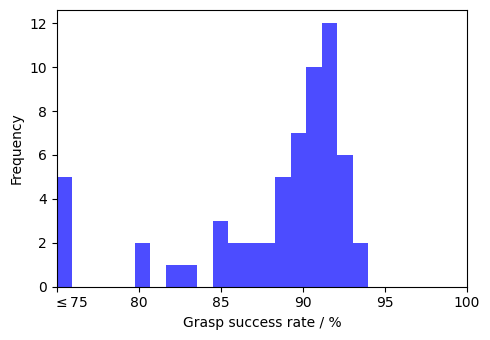

In [3]:
def plot_histogram(data, num_bins, bottom=None):
    plt.hist(data, bins=num_bins, bottom=bottom, color='blue', alpha=0.7)
    plt.xlabel('z value')
    plt.ylabel('Frequency')
    plt.title('Sensor calibration errors, normalised by standard deviation')

# Path to your CSV file (replace 'data.csv' with your file path)
csv_file_path = 'training_spread.csv'

# Load data from CSV file
data = load_data_from_csv(csv_file_path)

# Extract the column of interest (replace 'column_name' with the name of the column you want to plot)
column_name = ' set8_fullset_1500'
data_to_plot = np.array(data[column_name]) * 100
data_to_plot = np.clip(data_to_plot, 75, 100)
num_bins = 20

fig, axs = plt.subplots(1, 1)

_, bins, patches = axs.hist(data_to_plot, bins=num_bins, color="blue", alpha=0.7)
axs.set_xlabel("Grasp success rate / %")
axs.set_ylabel("Frequency")
axs.set_xlim([75, 100])

# xlabels = np.round(bins[0:].astype(float),2).astype(str)
# xlabels[0] += '+'
# N_labels = len(xlabels)

# plt.xticks(num_bins * np.arange(N_labels))
# axs.set_xticklabels(xlabels)
# axs.set_xlim([0.75, 1.0])

labels = axs.get_xticklabels()
labels[0] = r"      $\leq$75"
axs.set_xticklabels(labels)

fig.set_size_inches(5, 3.5)
fig.tight_layout()

if True and overwrite: fig.savefig(save_path + "training_spread.png")

In [4]:
import scipy.stats as stats
import math

confidence_level = 0.95
stdevs_from_mean = 1.0

probability_of_success = 1 - stats.norm.cdf(stdevs_from_mean)
n = math.ceil(math.log(1 - confidence_level) / math.log(1 - probability_of_success))

print(f"Number of runs needed to have {confidence_level*100:.0f}% confidence at least one is greater than {stdevs_from_mean} standard deviations above the mean:", n)

Number of runs needed to have 95% confidence at least one is greater than 1.0 standard deviations above the mean: 18


In [5]:
import math

n = 15  # number of runs
confidence_level = 0.95

probability_of_success = 1 - (1 - confidence_level) ** (1 / n)
stdevs_from_mean = -stats.norm.ppf(probability_of_success)

print("Probability of success:", probability_of_success)
print(f"Given {n} runs, there is {confidence_level*100:.0f}% confidence at least one is greater than {stdevs_from_mean:.2f} standard deviations above the mean")

Probability of success: 0.18103627252208465
Given 15 runs, there is 95% confidence at least one is greater than 0.91 standard deviations above the mean


In [10]:
def make_tm():
  tm = TrainingManager(log_level=0)
  tm.settings["savedir"] = "/home/luke/mujoco-devel/rl/models/"
  tm.trainer = tm.make_trainer(None, None)
  return tm

def get_jobs_from_timestamp(timestamp, run_name_prefix=None):
  """
  Find all the jobs with a particular timestamp
  """

  tm = make_tm()
  tm.set_group_run_name(job_num=1, timestamp=timestamp, prefix=run_name_prefix)
  match_str = tm.run_name[:-3]

  # get all the run folder corresponding to this timestamp
  group_path = tm.trainer.savedir + "/" + tm.group_name
  run_folders = [x for x in os.listdir(group_path) if x.startswith(match_str)]

  job_nums = []

  for folder in run_folders:
    num = folder.split(match_str)[-1][2:] # from _A5 -> 5"
    job_nums.append(int(num))

  # sort into numeric ascending order
  job_nums.sort()

  # check for failures
  if len(job_nums) == 0:
    print(f"launch_training.py warning: get_jobs_from_timestamp found zero trainings matching '{match_str}'")

  return job_nums

def load_results(timestamp, jobs=None):
  """
  Load track results for a series of trainings
  """

  if jobs is None:
    jobs = get_jobs_from_timestamp(timestamp)

  tm = make_tm()
  trackdata = []

  for j in jobs:

    # load tracking information for this training
    tm.load(job_num=j, timestamp=timestamp, trackonly=True)
    trackdata.append(tm.trainer.track)

  return trackdata

#

Number of runs used 16 out of 20


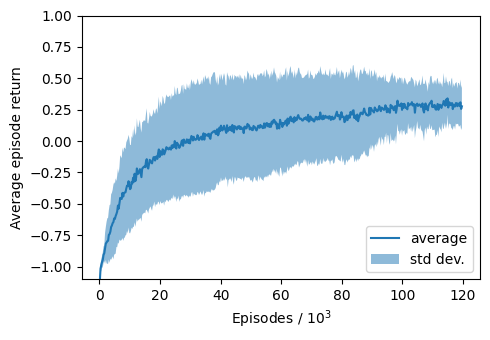

In [27]:
timestamp = "17-04-24_15-50"
data = load_results(timestamp=timestamp)

# get vectors as numpy arrays, and only count trainings that finished
data_length = 0
for i, d in enumerate(data):
  # print(i, "length", len(d.train_avg_rewards))
  if np.max(d.avg_successful_grasp) < 0.5: continue
  if len(d.train_avg_rewards) > data_length:
    data_length = len(d.train_avg_rewards)
    episodes = d.train_avg_episodes
    rewards = [d.train_avg_rewards]
  elif len(d.train_avg_rewards) == data_length:
    rewards.append(d.train_avg_rewards)

print(f"Number of runs used {len(rewards)} out of {len(data)}")

eps = episodes / 1e3
avg = np.average(rewards, axis=0)
lstd = avg - np.std(rewards, axis=0)
ustd = avg + np.std(rewards, axis=0)

fig, axs = plt.subplots(1, 1)

# axs.plot(episodes, np.min(rewards, axis=0), "--", label="min",)
axs.plot(eps, avg, label="average")
# axs.plot(episodes, np.max(rewards, axis=0), "--", label="max",)
axs.fill_between(eps, lstd, ustd, alpha=0.5, label="std dev.")
axs.legend(loc="lower right")
axs.set_ylabel("Average episode return")
axs.set_xlabel(r"Episodes / $10^{3}$")
axs.set_ybound(lower=-1.1, upper=1.0)
fig.set_size_inches(5, 3.5)
fig.tight_layout()

In [8]:
print(data)

[<Trainer.TrackTraining object at 0x7f847cfd1400>, <Trainer.TrackTraining object at 0x7f847cfd18e0>, <Trainer.TrackTraining object at 0x7f847cfd16d0>, <Trainer.TrackTraining object at 0x7f847cfd17f0>, <Trainer.TrackTraining object at 0x7f847cfd1ac0>, <Trainer.TrackTraining object at 0x7f847cfd1b50>, <Trainer.TrackTraining object at 0x7f847cfd1af0>, <Trainer.TrackTraining object at 0x7f847cfd1be0>, <Trainer.TrackTraining object at 0x7f847cfd19a0>, <Trainer.TrackTraining object at 0x7f847cfc87c0>, <Trainer.TrackTraining object at 0x7f847cfc8670>, <Trainer.TrackTraining object at 0x7f847cfc8dc0>, <Trainer.TrackTraining object at 0x7f847cfc8b80>, <Trainer.TrackTraining object at 0x7f847cfc82b0>, <Trainer.TrackTraining object at 0x7f847cfc8760>, <Trainer.TrackTraining object at 0x7f847cfc8340>, <Trainer.TrackTraining object at 0x7f847cfc8e80>, <Trainer.TrackTraining object at 0x7f847cfc8e50>, <Trainer.TrackTraining object at 0x7f847cfd1640>, <Trainer.TrackTraining object at 0x7f847cfd1730>]